extract feature sequence

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("dependencies")
from helpers import *
from music21 import *
from music21.repeat import Expander
from gensim.models import FastText
import numpy as np
import pickle
import matplotlib.pyplot as plt
import librosa

In [2]:
from music21 import converter, stream

# Load and linearize the MIDI file
sample_score = converter.parse('TET01.mid')  # Change this path to your MIDI file location
linearized_sample_score = sample_score.expandRepeats()  # Unfolds repeat measures, if any

# Display the score - this requires having an environment capable of displaying sheet music
#linearized_sample_score.show()




In [17]:
!pip install mido

   ---------------------------------------- 0.0/54.6 kB ? eta -:--:--
   ------- -------------------------------- 10.2/54.6 kB ? eta -:--:--
   ------------------------------ --------- 41.0/54.6 kB 393.8 kB/s eta 0:00:01
   ---------------------------------------- 54.6/54.6 kB 472.1 kB/s eta 0:00:00


In [19]:
from mido import MidiFile

# 载入MIDI文件
midi_file_path = 'TET01.mid'
midi_file = MidiFile(midi_file_path)

# count how many tracks in the midi file
velocity = []
for track in midi_file.tracks:
    for event in track:
        if event.type == 'note_on':
            velocity.append(event.velocity)
        
print(velocity)

[48, 31, 35, 0, 0, 34, 0, 22, 77, 0, 40, 0, 0, 42, 0, 0, 74, 52, 0, 51, 0, 0, 51, 54, 0, 0, 86, 55, 0, 0, 56, 0, 75, 48, 46, 0, 44, 0, 0, 51, 0, 70, 48, 0, 0, 0, 44, 0, 66, 43, 0, 47, 64, 0, 0, 57, 46, 0, 43, 0, 0, 0, 40, 0, 48, 0, 71, 40, 31, 0, 0, 0, 77, 76, 0, 64, 0, 60, 0, 61, 67, 43, 0, 0, 53, 0, 60, 0, 66, 47, 0, 0, 52, 0, 55, 0, 68, 45, 0, 0, 63, 67, 0, 50, 0, 0, 0, 70, 45, 47, 0, 82, 0, 48, 0, 80, 51, 0, 0, 0, 0, 74, 41, 0, 80, 0, 0, 81, 0, 77, 0, 0, 51, 78, 0, 63, 0, 0, 66, 50, 66, 0, 0, 0, 54, 44, 45, 0, 0, 0, 49, 44, 35, 0, 46, 0, 0, 0, 59, 43, 42, 0, 0, 59, 66, 0, 0, 0, 22, 82, 66, 67, 0, 0, 0, 0, 71, 61, 51, 0, 0, 0, 56, 70, 56, 0, 0, 74, 63, 52, 0, 56, 82, 70, 0, 0, 0, 0, 0, 0, 88, 66, 71, 0, 0, 0, 88, 56, 44, 80, 0, 50, 64, 50, 0, 0, 0, 0, 0, 0, 79, 49, 50, 60, 0, 0, 0, 0, 72, 45, 56, 43, 0, 0, 0, 0, 59, 38, 39, 46, 0, 51, 0, 45, 0, 37, 39, 0, 0, 0, 0, 0, 80, 55, 53, 0, 75, 76, 0, 0, 0, 51, 66, 82, 0, 0, 0, 89, 79, 66, 0, 0, 0, 0, 86, 67, 67, 0, 0, 0, 82, 61, 61, 0, 74, 

velocity

In [3]:
#Cast measures as lists of highest velocities
velocity_measure_sequence = []
for part in linearized_sample_score.getElementsByClass(stream.Part):  # Iterate through each part
    for measure in part.getElementsByClass(stream.Measure):  # Iterate through each measure in the part
        max_velocity = 0  # Initialize maximum velocity for this measure
        for event in measure.recurse().notes:  # Access all notes and chords within the measure
            if event.isNote:  # Check if the event is a single note
                max_velocity = max(max_velocity, event.volume.velocity)  # Update maximum velocity
            elif event.isChord:  # Check if the event is a chord
                chord_max_velocity = max(note.volume.velocity for note in event.notes)  # Get the highest velocity in the chord
                max_velocity = max(max_velocity, chord_max_velocity)  # Update maximum velocity
        velocity_measure_sequence.append(max_velocity)  # Append the highest velocity for this measure

# Print the sequence of maximum velocities for verification
print(velocity_measure_sequence)

[0, 77, 86, 77, 67, 82, 81, 82, 88, 89, 83, 68, 47, 89, 91, 79, 97, 90, 82, 93, 92, 98, 97, 80, 70, 71, 83, 84, 87, 86, 73, 88, 72, 65, 81, 92, 92, 97, 76, 78, 76, 77, 73, 67, 85, 92, 86, 91, 92, 98, 90, 107, 104, 102, 94, 65, 71, 84, 85, 71, 57, 58, 69, 62, 62, 62, 81, 89, 93, 96, 98, 99, 75, 76, 64, 55, 83, 62, 50, 68, 70, 71, 72, 67, 77, 75, 85, 82, 86, 80, 60, 63, 92, 90, 84, 91, 91, 90, 92, 83, 86, 93, 92, 97, 94, 74, 76, 87, 81, 71, 93, 85, 88, 85, 79, 82, 95, 98, 98, 92, 79, 80, 81, 80, 78, 83, 87, 88, 75, 92, 98, 95, 96, 103, 102, 98]


pitch

In [4]:
# Cast measures as lists of highest pitches
pitch_measure_sequence = []
for part in linearized_sample_score.getElementsByClass(stream.Part):  # Iterate through each part
    for measure in part.getElementsByClass(stream.Measure):  # Iterate through each measure in the part
        max_pitch = 0  # Initialize maximum pitch for this measure
        for event in measure.recurse().notes:  # Access all notes and chords within the measure
            if event.isNote:  # Check if the event is a single note
                max_pitch = max(max_pitch, event.pitch.midi)  # Update maximum pitch
            elif event.isChord:  # Check if the event is a chord
                chord_max_pitch = max(note.pitch.midi for note in event.notes)  # Get the highest pitch in the chord
                max_pitch = max(max_pitch, chord_max_pitch)  # Update maximum pitch
        pitch_measure_sequence.append(max_pitch)  # Append the highest pitch for this measure

# Print the sequence of maximum pitches for verification
print(pitch_measure_sequence)


[0, 72, 79, 77, 72, 74, 72, 84, 79, 86, 82, 84, 77, 81, 82, 81, 81, 80, 84, 84, 84, 79, 80, 76, 79, 76, 81, 79, 78, 79, 79, 81, 79, 67, 67, 68, 68, 67, 67, 67, 67, 69, 67, 67, 81, 83, 77, 79, 79, 77, 84, 84, 88, 84, 84, 76, 79, 77, 81, 72, 64, 67, 65, 69, 67, 67, 67, 67, 72, 74, 79, 80, 81, 67, 65, 65, 65, 82, 82, 72, 79, 77, 74, 67, 74, 70, 84, 79, 86, 82, 82, 84, 74, 82, 82, 81, 80, 79, 78, 77, 82, 81, 84, 84, 73, 72, 72, 72, 74, 81, 84, 81, 86, 84, 72, 72, 73, 73, 72, 70, 72, 68, 74, 74, 72, 82, 86, 88, 84, 84, 84, 77, 82, 89, 77, 77]


SSM

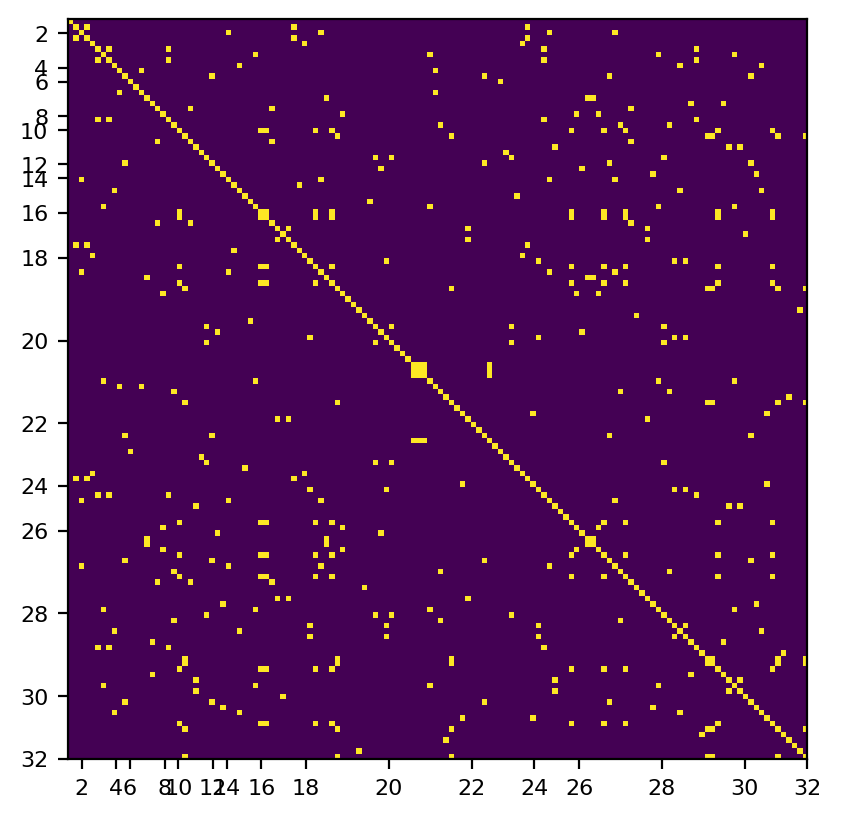

In [23]:
# Kronecker function for upcoming matrix (do not modify)
def kronecker_delta(x, y):
    if x == y:
        return 1
    else:
        return 0

# Create similarity matrix from MIDI note numbers
def calculate_ssm(sequence):
    length = len(sequence)
    ssm = np.zeros((length, length))

    ## STUDENT SECTION - REMOVE ALL OR SOME OF CODE ##
    i = 0
    for element_i in sequence:
        j = 0
        for element_j in sequence:
            ssm[i][j] = kronecker_delta(element_i, element_j)
            j += 1
        i += 1
    ## END STUDENT SECTION  ##
    
    return ssm

self_sim_mat1 = calculate_ssm(velocity_measure_sequence)

# Display the SSM - there should be a bright diagonal running f rom the top left to the bottom right
plt.imshow(self_sim_mat1, cmap='viridis', interpolation='nearest', extent=[0,214,214,0])
plt.xticks([4, 14, 18, 28, 32, 42, 46, 56, 69, 93, 117, 135, 148, 172, 196, 214], ['2', '4', '6', '8', '10', '12', '14', '16', '18', '20', '22', '24', '26', '28', '30', '32'], fontsize=8)
plt.yticks([4, 14, 18, 28, 32, 42, 46, 56, 69, 93, 117, 135, 148, 172, 196, 214], ['2', '4', '6', '8', '10', '12', '14', '16', '18', '20', '22', '24', '26', '28', '30', '32'], fontsize=8)
plt.show()

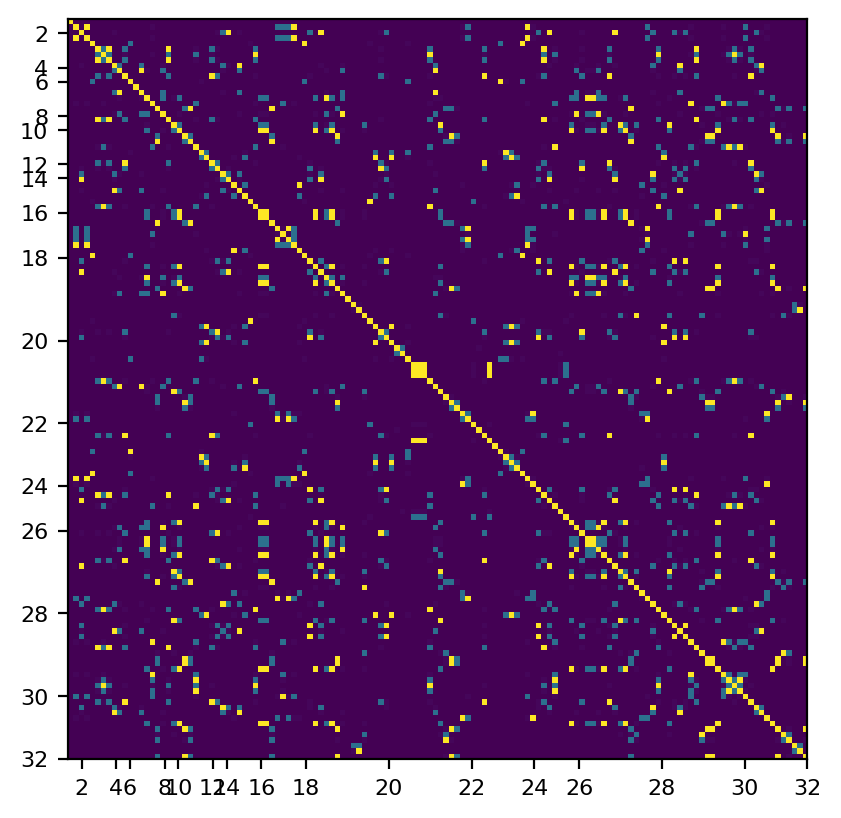

In [24]:
import numpy as np

def calculate_ssm_euclidean(sequence):
    length = len(sequence)
    ssm = np.zeros((length, length))
    for i in range(length):
        for j in range(length):
            ssm[i][j] = np.exp(-np.linalg.norm(sequence[i] - sequence[j])**2)
    return ssm

self_sim_mat3 = calculate_ssm_euclidean(velocity_measure_sequence)

# Display the SSM - there should be a bright diagonal running f rom the top left to the bottom right
plt.imshow(self_sim_mat3, cmap='viridis', interpolation='nearest', extent=[0,214,214,0])
plt.xticks([4, 14, 18, 28, 32, 42, 46, 56, 69, 93, 117, 135, 148, 172, 196, 214], ['2', '4', '6', '8', '10', '12', '14', '16', '18', '20', '22', '24', '26', '28', '30', '32'], fontsize=8)
plt.yticks([4, 14, 18, 28, 32, 42, 46, 56, 69, 93, 117, 135, 148, 172, 196, 214], ['2', '4', '6', '8', '10', '12', '14', '16', '18', '20', '22', '24', '26', '28', '30', '32'], fontsize=8)
plt.show()

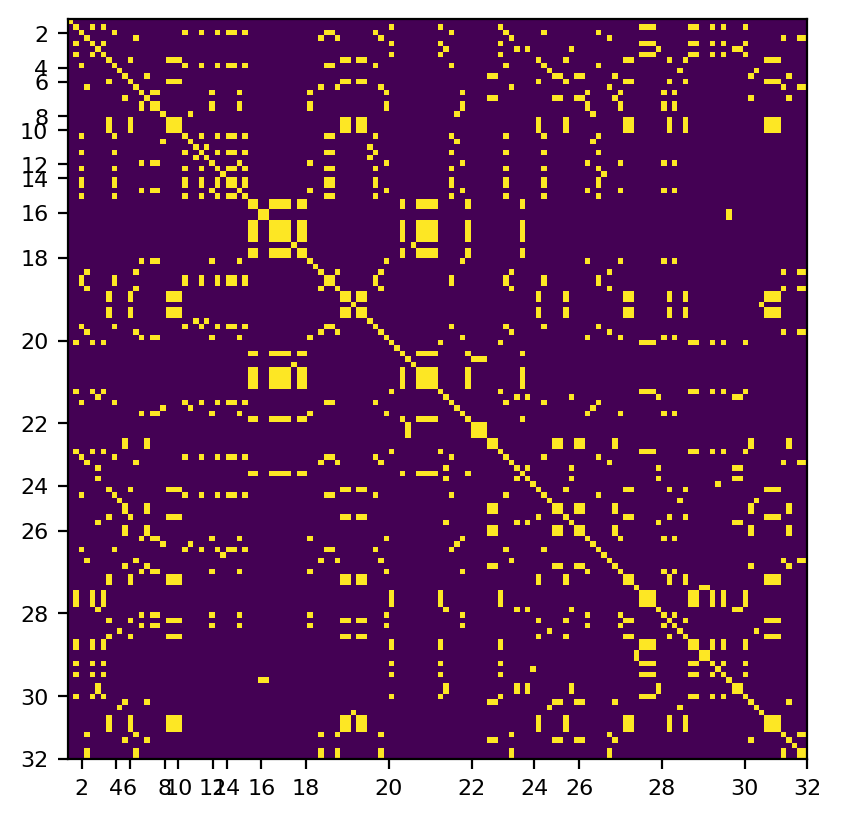

In [6]:
self_sim_mat2 = calculate_ssm(pitch_measure_sequence)

# Display the SSM - there should be a bright diagonal running f rom the top left to the bottom right
plt.imshow(self_sim_mat2, cmap='viridis', interpolation='nearest', extent=[0,214,214,0])
plt.xticks([4, 14, 18, 28, 32, 42, 46, 56, 69, 93, 117, 135, 148, 172, 196, 214], ['2', '4', '6', '8', '10', '12', '14', '16', '18', '20', '22', '24', '26', '28', '30', '32'], fontsize=8)
plt.yticks([4, 14, 18, 28, 32, 42, 46, 56, 69, 93, 117, 135, 148, 172, 196, 214], ['2', '4', '6', '8', '10', '12', '14', '16', '18', '20', '22', '24', '26', '28', '30', '32'], fontsize=8)
plt.show()

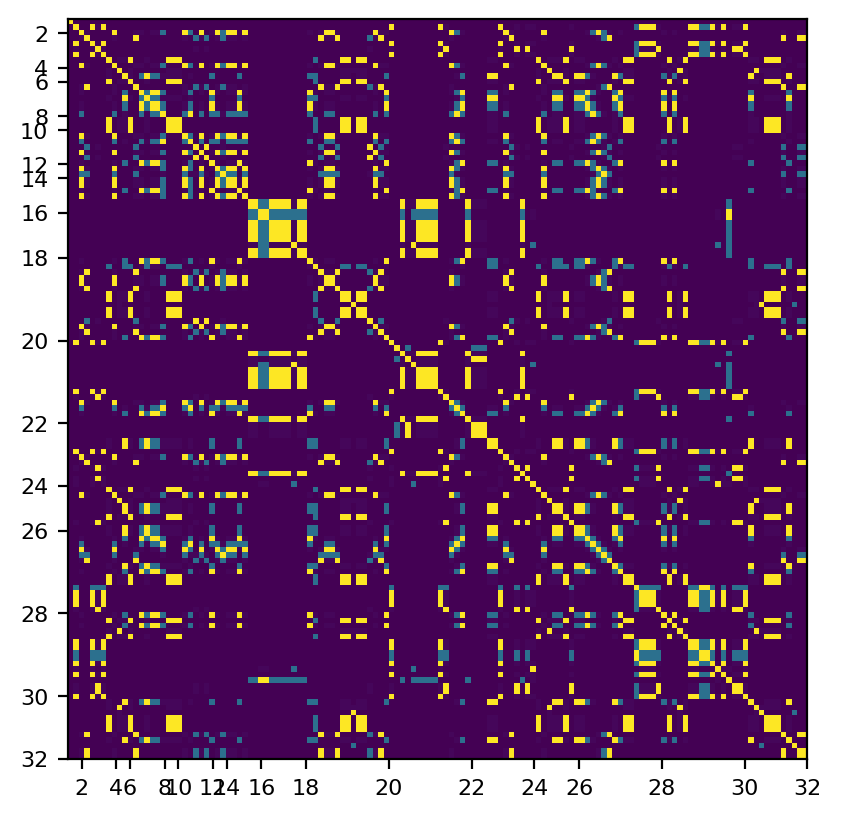

In [15]:
self_sim_mat4 = calculate_ssm_euclidean(pitch_measure_sequence)

# Display the SSM - there should be a bright diagonal running f rom the top left to the bottom right
plt.imshow(self_sim_mat4, cmap='viridis', interpolation='nearest', extent=[0,214,214,0])
plt.xticks([4, 14, 18, 28, 32, 42, 46, 56, 69, 93, 117, 135, 148, 172, 196, 214], ['2', '4', '6', '8', '10', '12', '14', '16', '18', '20', '22', '24', '26', '28', '30', '32'], fontsize=8)
plt.yticks([4, 14, 18, 28, 32, 42, 46, 56, 69, 93, 117, 135, 148, 172, 196, 214], ['2', '4', '6', '8', '10', '12', '14', '16', '18', '20', '22', '24', '26', '28', '30', '32'], fontsize=8)
plt.show()

Novelty curve

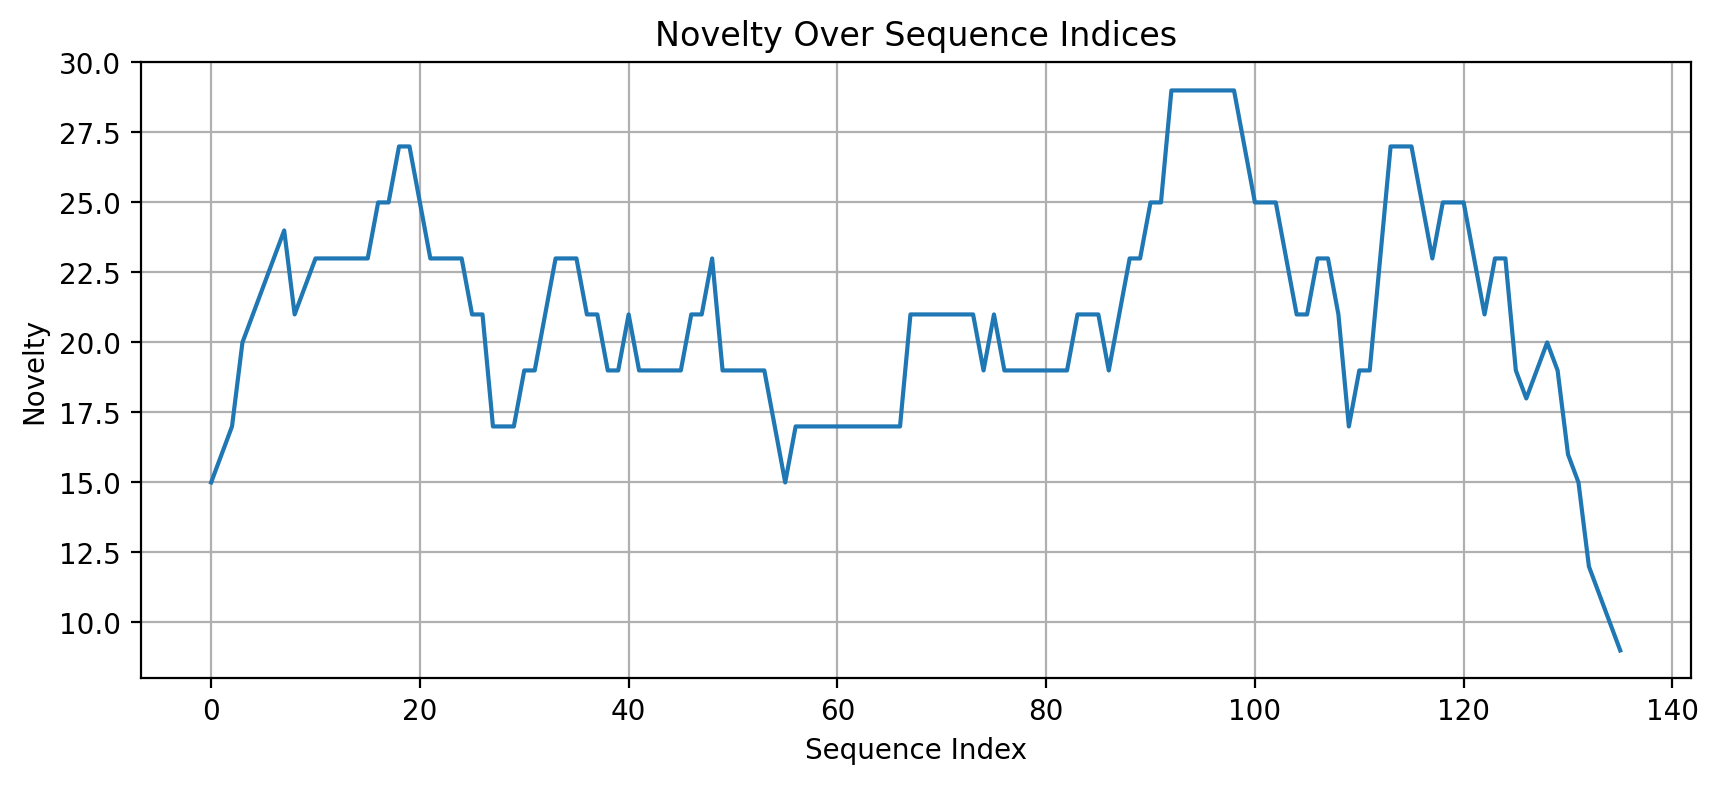

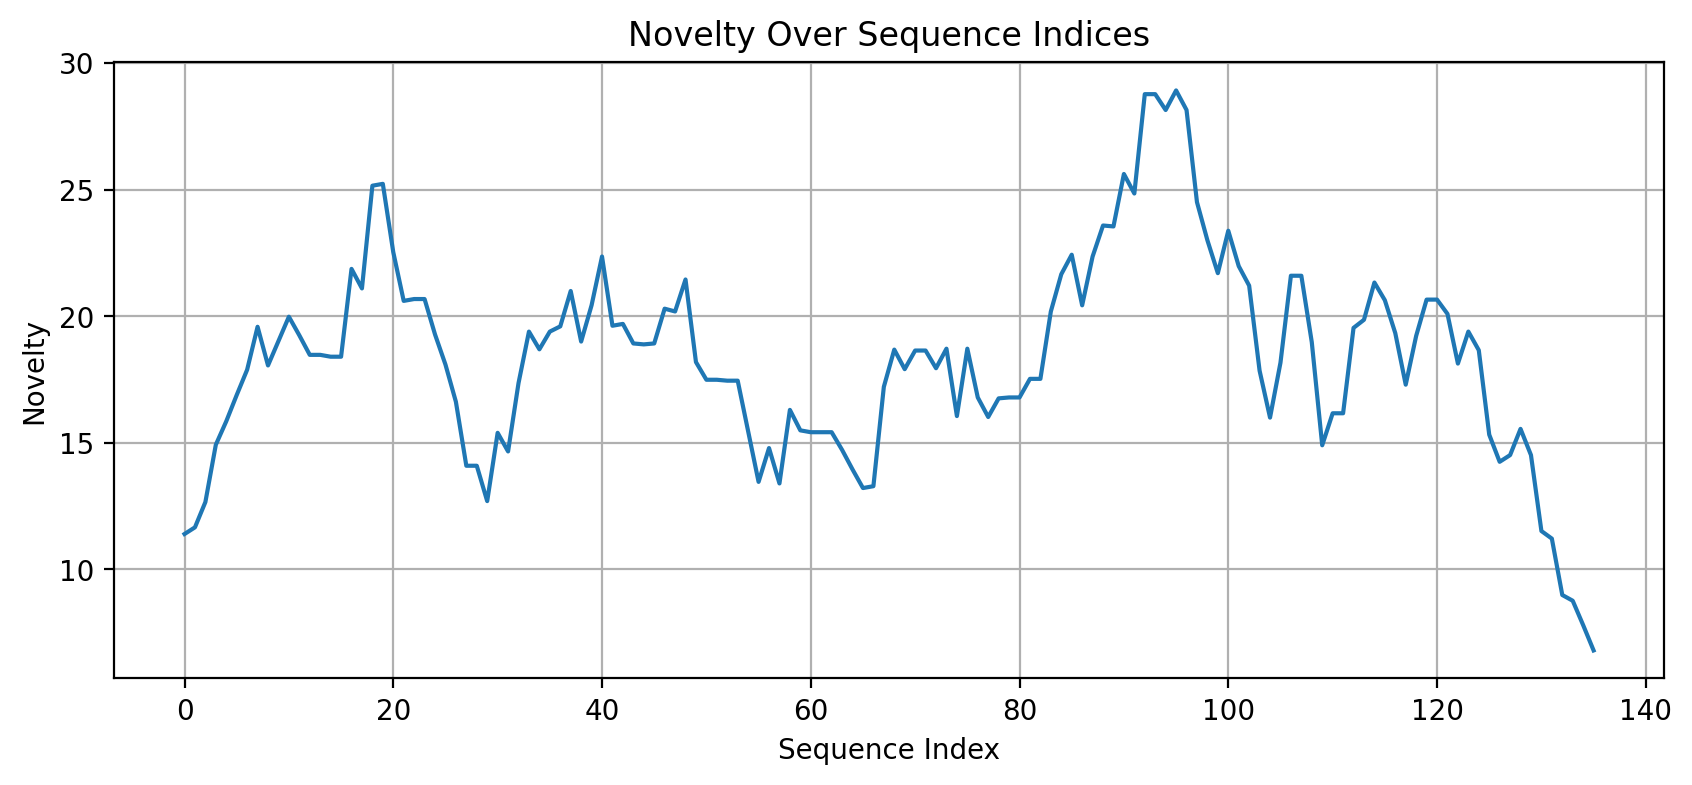

In [25]:
import numpy as np
import matplotlib.pyplot as plt

def build_kernel(L):
    """Build a checkerboard kernel."""
    kernel = np.zeros((2*L + 1, 2*L + 1))
    for i in range(2*L + 1):
        for j in range(2*L + 1):
            kernel[i, j] = (-1)**(i + j)
    return kernel

def novelty_from_ssm(SSM, L):
    kernel = build_kernel(L)
    N = SSM.shape[0]
    M = 2 * L + 1
    novelty = np.zeros(N)
    S_padded = np.pad(SSM, ((L, L), (L, L)), mode='constant')
    for n in range(N):
        novelty[n] = np.sum(S_padded[n:n+M, n:n+M] * kernel)
    return novelty

def plot_novelty(novelty):
    """Plot novelty function with indices."""
    indices = np.arange(len(novelty))
    plt.figure(figsize=(10, 4))
    plt.plot(indices, novelty)
    plt.title('Novelty Over Sequence Indices')
    plt.xlabel('Sequence Index')
    plt.ylabel('Novelty')
    plt.grid(True)
    plt.show()


# self_sim_mat = np.random.rand(100, 100)  # Example SSM
novelty = novelty_from_ssm(self_sim_mat1, 10)
plot_novelty(novelty)  # Plot using sequence indices
novelty2 = novelty_from_ssm(self_sim_mat3, 10)
plot_novelty(novelty2)  # Plot using sequence indices


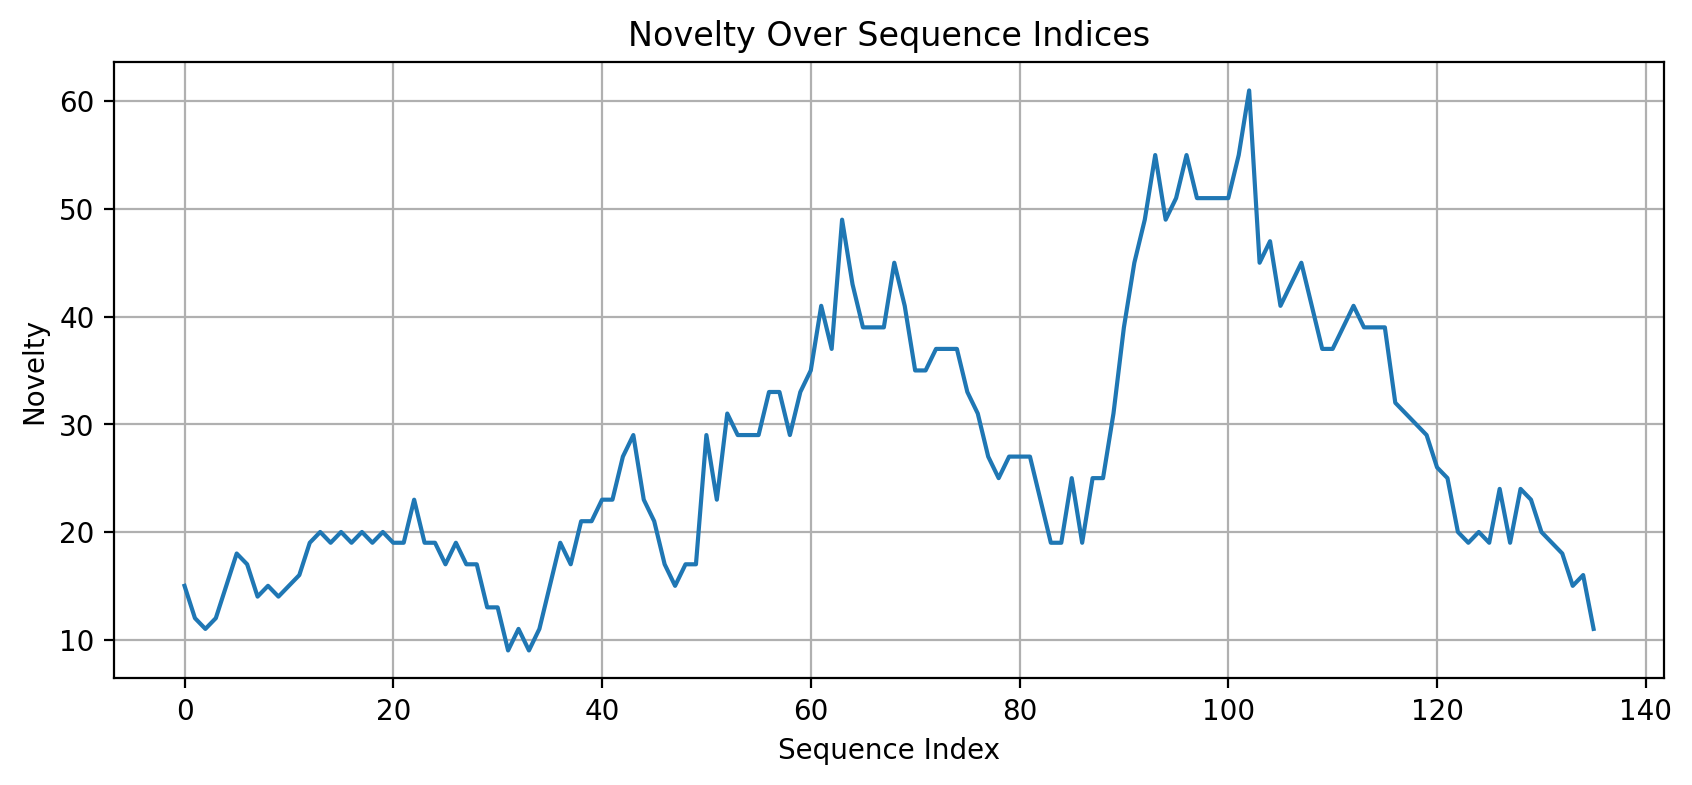

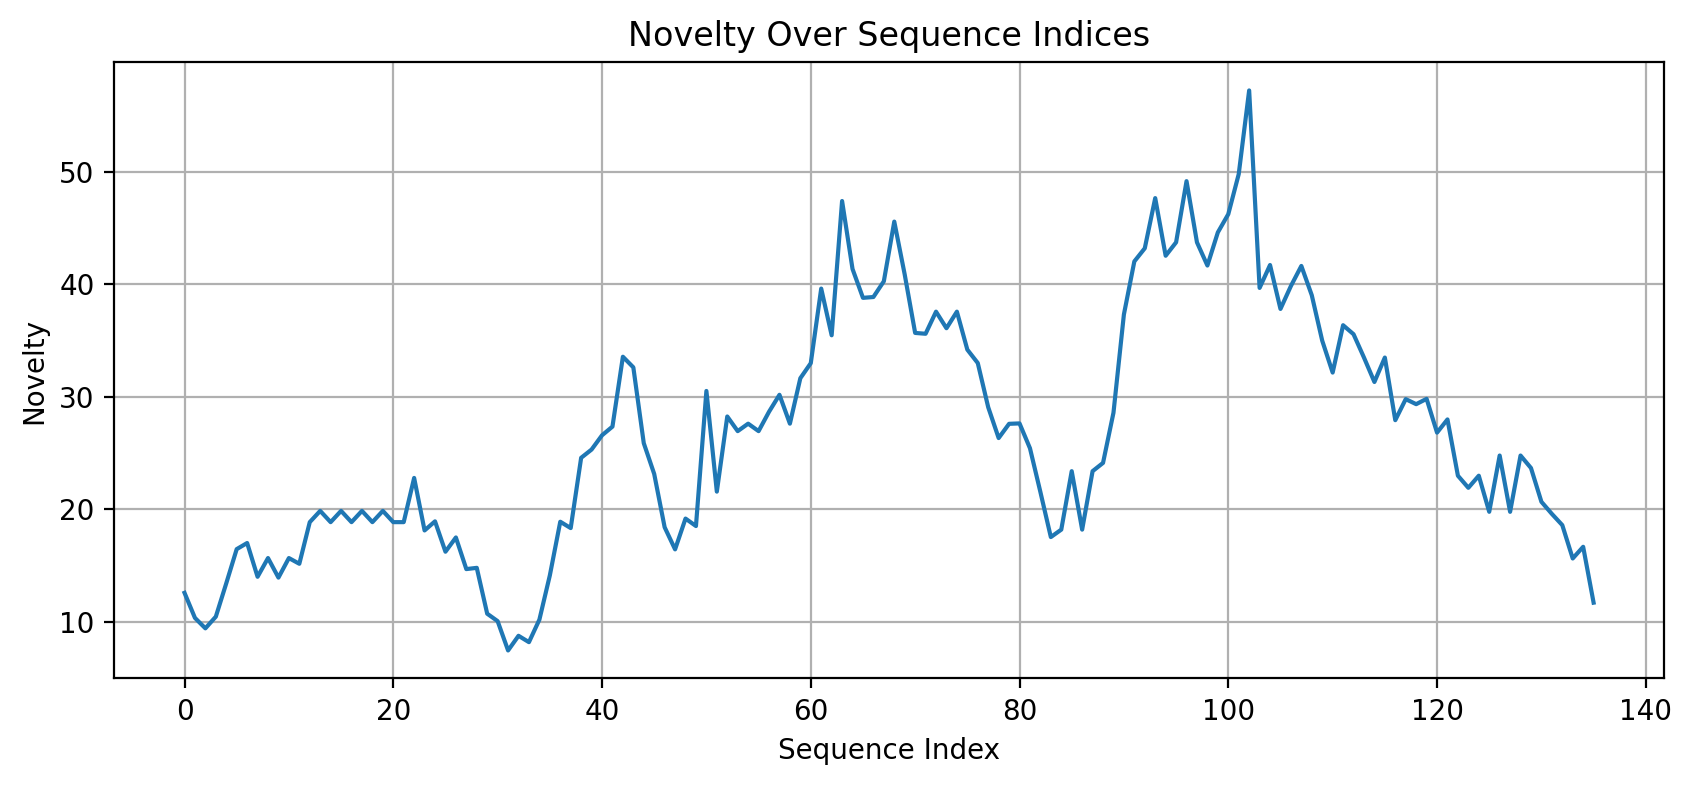

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def build_kernel(L):
    """Build a checkerboard kernel."""
    kernel = np.zeros((2*L + 1, 2*L + 1))
    for i in range(2*L + 1):
        for j in range(2*L + 1):
            kernel[i, j] = (-1)**(i + j)
    return kernel

def novelty_from_ssm(SSM, L):
    kernel = build_kernel(L)
    N = SSM.shape[0]
    M = 2 * L + 1
    novelty = np.zeros(N)
    S_padded = np.pad(SSM, ((L, L), (L, L)), mode='constant')
    for n in range(N):
        novelty[n] = np.sum(S_padded[n:n+M, n:n+M] * kernel)
    return novelty

def plot_novelty(novelty):
    """Plot novelty function with indices."""
    indices = np.arange(len(novelty))
    plt.figure(figsize=(10, 4))
    plt.plot(indices, novelty)
    plt.title('Novelty Over Sequence Indices')
    plt.xlabel('Sequence Index')
    plt.ylabel('Novelty')
    plt.grid(True)
    plt.show()


# self_sim_mat = np.random.rand(100, 100)  # Example SSM
novelty = novelty_from_ssm(self_sim_mat2, 20)
plot_novelty(novelty)  # Plot using sequence indices
novelty2 = novelty_from_ssm(self_sim_mat4, 20)
plot_novelty(novelty2)  # Plot using sequence indices
